In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import multiprocessing
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import os
from pathlib import Path
import pandas as pd
import kagglehub as kh

# 1) Download locally; this returns the root folder path
root = kh.dataset_download("daveianhickey/2000-16-traffic-flow-england-scotland-wales")
print("Dataset root:", root)

# 2) See what files are available
csvs = list(Path(root).rglob("*.csv"))
for i, p in enumerate(csvs[:15], 1):
    print(i, p.relative_to(root))  # peek at a few CSVs

# 3) Pick one and load it
target = Path(root) / "accidents_2005_to_2007.csv"   # <- adjust if you pick a different file
accidentdf = pd.read_csv(target, low_memory=False)
# print(df.shape)
# df.head()


/home/gdyang/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset root: /home/gdyang/.cache/kagglehub/datasets/daveianhickey/2000-16-traffic-flow-england-scotland-wales/versions/10
1 accidents_2005_to_2007.csv
2 ukTrafficAADF.csv
3 accidents_2012_to_2014.csv
4 accidents_2009_to_2011.csv


In [3]:
accidentdf1 = pd.read_csv(Path(root) / "accidents_2005_to_2007.csv" ,low_memory = False)
accidentdf2 = pd.read_csv(Path(root) / "accidents_2009_to_2011.csv",low_memory = False)
accidentdf3 = pd.read_csv(Path(root) / "accidents_2012_to_2014.csv",low_memory = False)

df_concat = pd.concat([accidentdf1, accidentdf2, accidentdf3])
print("Done")

Done


In [4]:
df = df_concat.drop(columns = ['Accident_Index','Location_Easting_OSGR',
                            'Location_Northing_OSGR','Date','LSOA_of_Accident_Location',
                            'Local_Authority_(District)','Local_Authority_(Highway)',
                            '1st_Road_Number','Longitude','Latitude',
                            '1st_Road_Class', 'Road_Type',
                            'Police_Force','Junction_Detail',
                            '2nd_Road_Class','2nd_Road_Number'
                            ])

# print(df.info())
df['Junction_Control'] = df['Junction_Control'].fillna('No junction')
df['Light_Conditions'] = df['Light_Conditions'].replace(
    {'Darkeness: No street lighting': 'Darkness: No street lighting'}
)
df['Special_Conditions_at_Site'] = df['Special_Conditions_at_Site'].fillna('None')
df['Carriageway_Hazards'] = df['Carriageway_Hazards'].fillna('None')


df = df.dropna()

scaler = sk.preprocessing.StandardScaler()
df[['Number_of_Vehicles', 'Number_of_Casualties']] = scaler.fit_transform(df[['Number_of_Vehicles', 'Number_of_Casualties']])

df = pd.get_dummies(df, columns = ['Day_of_Week', 'Time', 'Speed_limit', 'Junction_Control', 'Pedestrian_Crossing-Human_Control',
                                   'Road_Surface_Conditions', 'Pedestrian_Crossing-Physical_Facilities',
                                'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 
                                'Carriageway_Hazards', 'Urban_or_Rural_Area',
                               'Did_Police_Officer_Attend_Scene_of_Accident', 'Year'])
print("Done")

Done


In [5]:
df

,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6,Day_of_Week_7,...,Did_Police_Officer_Attend_Scene_of_Accident_Yes,Year_2005,Year_2006,Year_2007,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014
0,2,-1.163258,-0.425405,False,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
1,3,-1.163258,-0.425405,False,False,False,True,False,False,False,...,True,True,False,False,False,False,False,False,False,False
2,3,0.235391,-0.425405,False,False,False,False,True,False,False,...,True,True,False,False,False,False,False,False,False,False
3,3,-1.163258,-0.425405,False,False,False,False,False,True,False,...,True,True,False,False,False,False,False,False,False,False
4,3,-1.163258,-0.425405,False,True,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464692,2,0.235391,-0.425405,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
464693,3,0.235391,0.785395,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
464694,3,-1.163258,-0.425405,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
464695,2,1.634040,0.785395,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True


In [6]:
pca = sk.decomposition.PCA(n_components=2)
transform = pca.fit_transform(df)
print(transform)

[[-1.03355242 -1.70944967]
 [-1.31779727  0.33261318]
 [-0.31086343  0.56467189]
 ...
 [-0.8024564  -1.24559816]
 [ 2.08764395 -1.50705967]
 [ 1.10203659 -1.32068302]]


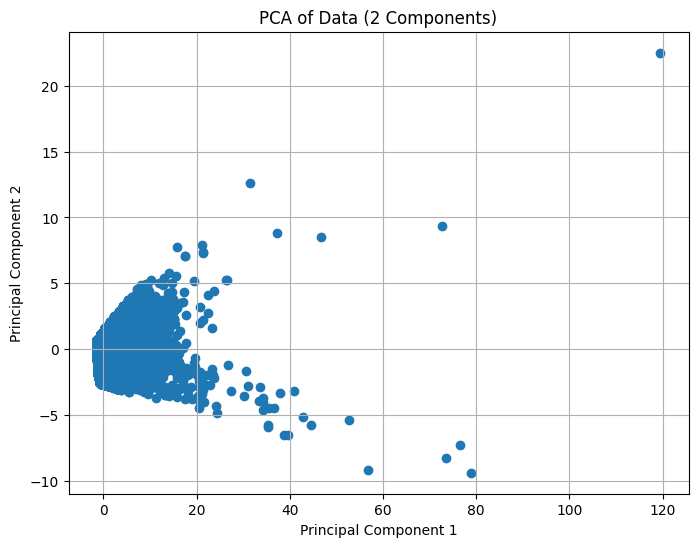

In [7]:
df_pca = pd.DataFrame(data = transform, columns = ['PC1', 'PC2'])

# Plot the 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Data (2 Components)')
plt.grid(True)
plt.show()

In [8]:
kmeans = sk.cluster.KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df_pca)

y = kmeans.predict(df_pca)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.41907485  0.59568348]
 [-0.13674778 -1.3166732 ]
 [ 2.03316576  0.15711356]]


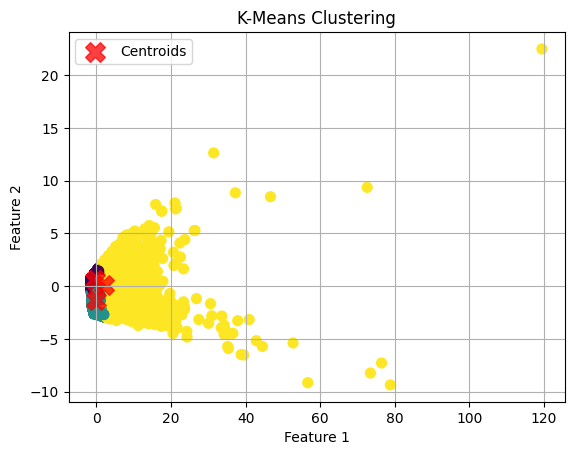

In [9]:
np_pca = df_pca.to_numpy()
plt.scatter(np_pca[:, 0], np_pca[:, 1], c=y, s=50, cmap='viridis')

plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroids')

plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

plt.show()

In [10]:

# --- config ---
k_range        = range(2, 11)
sil_sample     = 10000         # silhouette sample size (None -> full, but can be slow)

# --- data ---
X = df_pca.values  # use your preprocessed dataframe 'df'
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)


def test_inertia(X, centers):
    _, d = pairwise_distances_argmin_min(X, centers)
    return np.sum(d ** 2)

train_inertia, test_inertia_list = [], []
train_sil, test_sil = [], []

print("Evaluating across k …")
for k in tqdm(k_range, desc="k loop", unit="k"):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    km.fit(X_train)

    # train metrics
    train_inertia.append(km.inertia_)
    try:
        train_sil.append(silhouette_score(X_train, km.labels_, sample_size=sil_sample, random_state=0))
    except Exception:
        train_sil.append(np.nan)

    # test metrics
    ti = test_inertia(X_test, km.cluster_centers_)
    test_inertia_list.append(ti)

    test_labels = km.predict(X_test)
    if len(np.unique(test_labels)) >= 2:
        try:
            test_sil.append(silhouette_score(X_test, test_labels, sample_size=sil_sample, random_state=0))
        except Exception:
            test_sil.append(np.nan)
    else:
        test_sil.append(np.nan)

results = pd.DataFrame({
    "k": list(k_range),
    "train_inertia": train_inertia,
    "test_inertia": test_inertia_list,
    "train_silhouette": train_sil,
    "test_silhouette": test_sil
})
results


Evaluating across k …


k loop: 100%|██████████| 9/9 [00:21<00:00,  2.34s/k]


,k,train_inertia,test_inertia,train_silhouette,test_silhouette
0,2,1.742048e+06,439070.950623,0.455972,0.457991
1,3,1.044167e+06,262494.674398,0.495001,0.496811
2,4,8.291877e+05,208041.545503,0.471215,0.470316
3,5,6.835097e+05,171481.417202,0.467447,0.465131
4,6,6.155141e+05,154438.735056,0.395354,0.395550
5,7,5.546274e+05,139359.090457,0.396113,0.398183
6,8,4.015323e+05,101048.154109,0.507396,0.508085
7,9,3.594531e+05,91066.075315,0.507479,0.508130
8,10,3.298338e+05,82230.607309,0.507392,0.506942


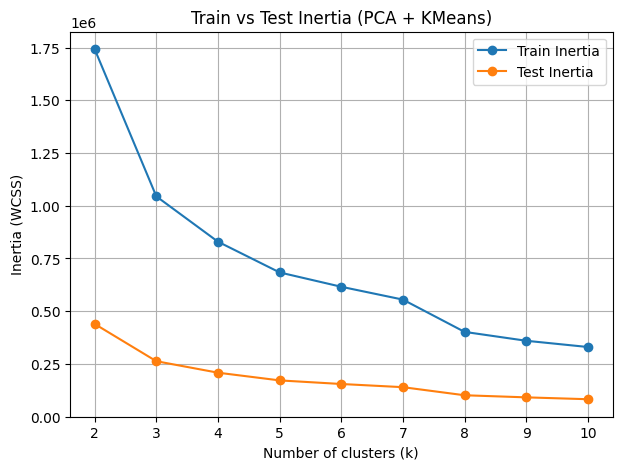

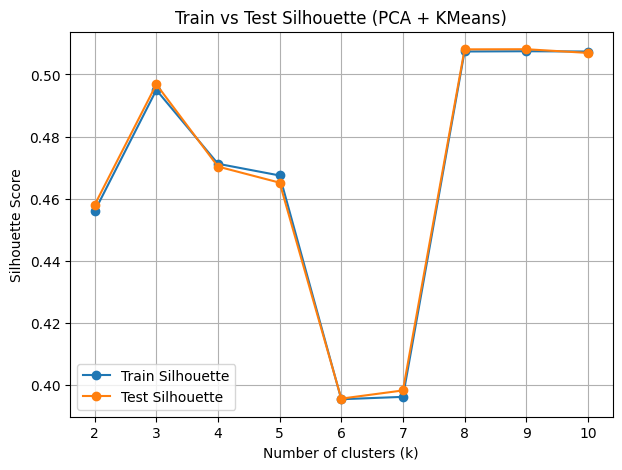

In [11]:
# Plotting
plt.figure(figsize=(7,5))
plt.plot(list(k_range), train_inertia, marker='o', label="Train Inertia")
plt.plot(list(k_range), test_inertia_list, marker='o', label="Test Inertia")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Train vs Test Inertia (PCA + KMeans)")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.plot(list(k_range), train_sil, marker='o', label="Train Silhouette")
plt.plot(list(k_range), test_sil, marker='o', label="Test Silhouette")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Train vs Test Silhouette (PCA + KMeans)")
plt.legend(); plt.grid(True); plt.show()


In [14]:
pca_3 = sk.decomposition.PCA(n_components=3)
transform_3 = pca_3.fit_transform(df)
print(pca_3.components_)

[[-1.03439745e-02  6.63707951e-01  7.06742667e-01 ... -1.86974075e-03
  -2.74985197e-03 -1.81533584e-03]
 [ 3.22695125e-02  3.26243539e-01 -8.49497489e-02 ... -2.18189822e-03
   3.41756830e-03  2.69425536e-03]
 [ 8.47767695e-02  6.04468023e-01 -5.24822162e-01 ...  7.32725507e-03
   1.43017869e-05  3.75659822e-03]]


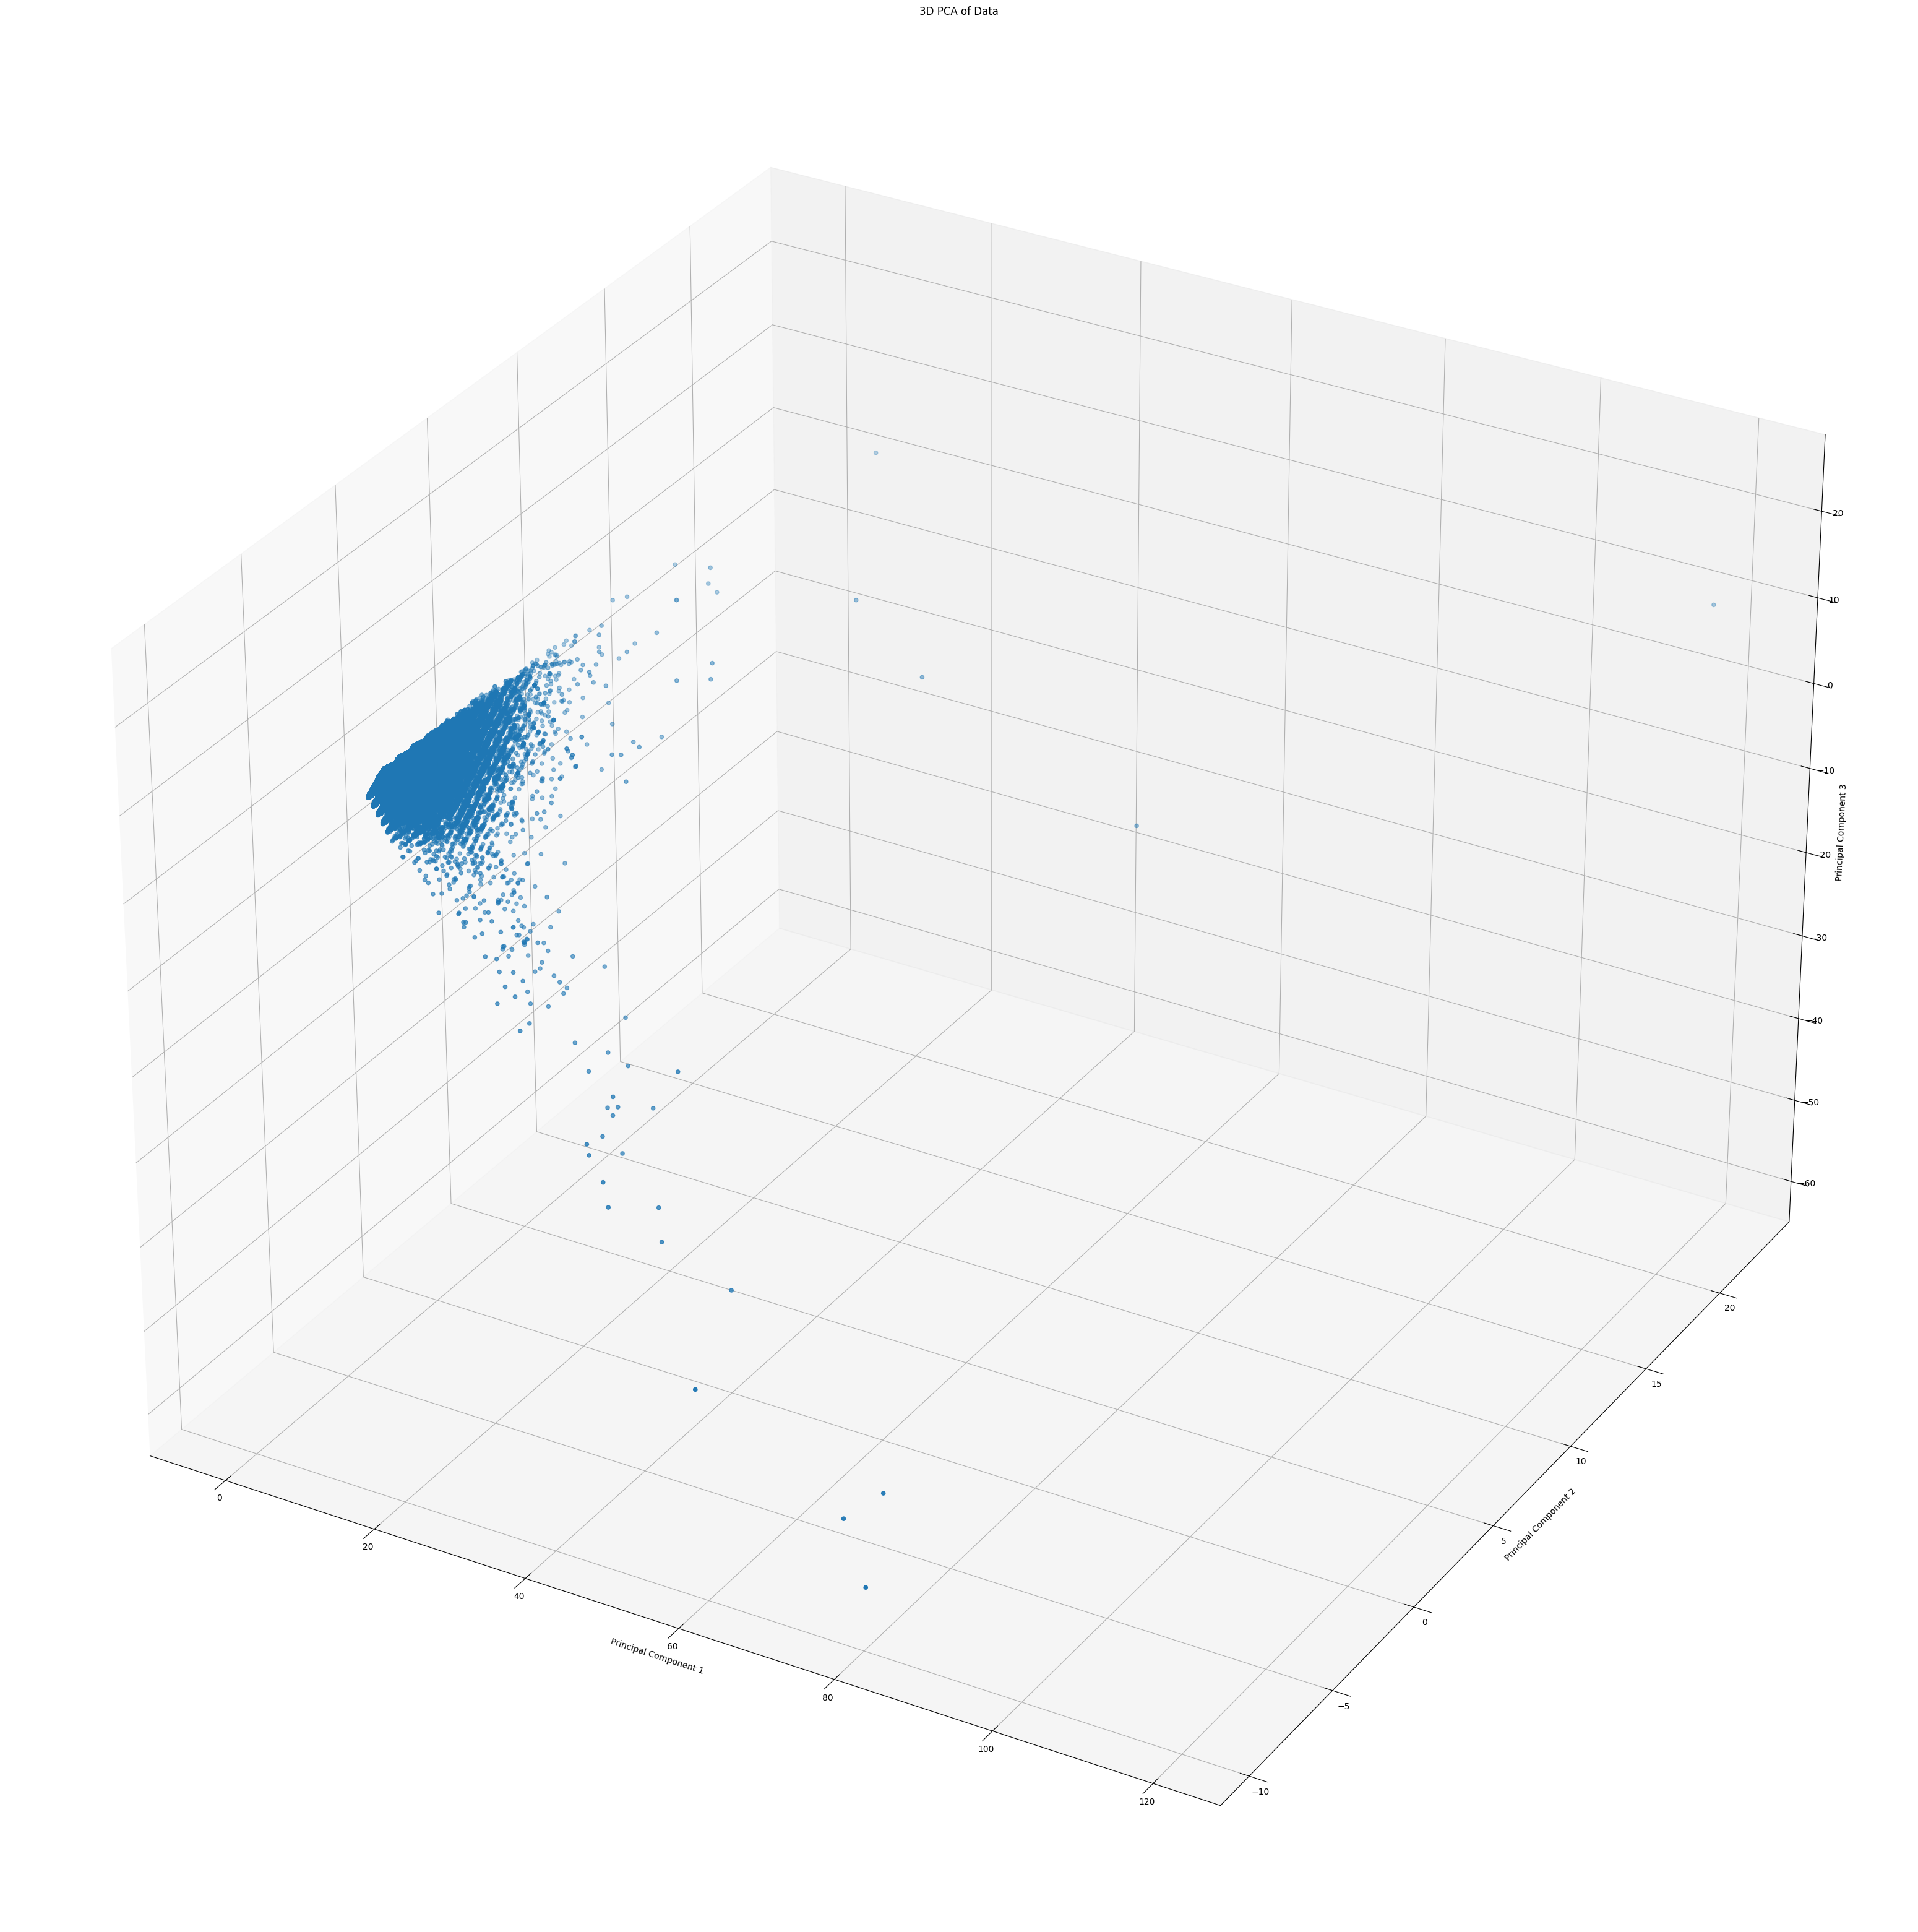

In [17]:
df_pca3 = pd.DataFrame(data = transform_3, columns = ['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize=(50,40))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(transform_3[:, 0], transform_3[:, 1], transform_3[:, 2])

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Data')

plt.show()


In [ ]:
kmeans3 = sk.cluster.KMeans(n_clusters=20, random_state=0, n_init="auto").fit(df_pca3)

y3 = kmeans3.predict(df_pca3)
centroids3 = kmeans3.cluster_centers_
labels3 = kmeans3.labels_
print(centroids3)

IndexError: index 2 is out of bounds for axis 1 with size 2

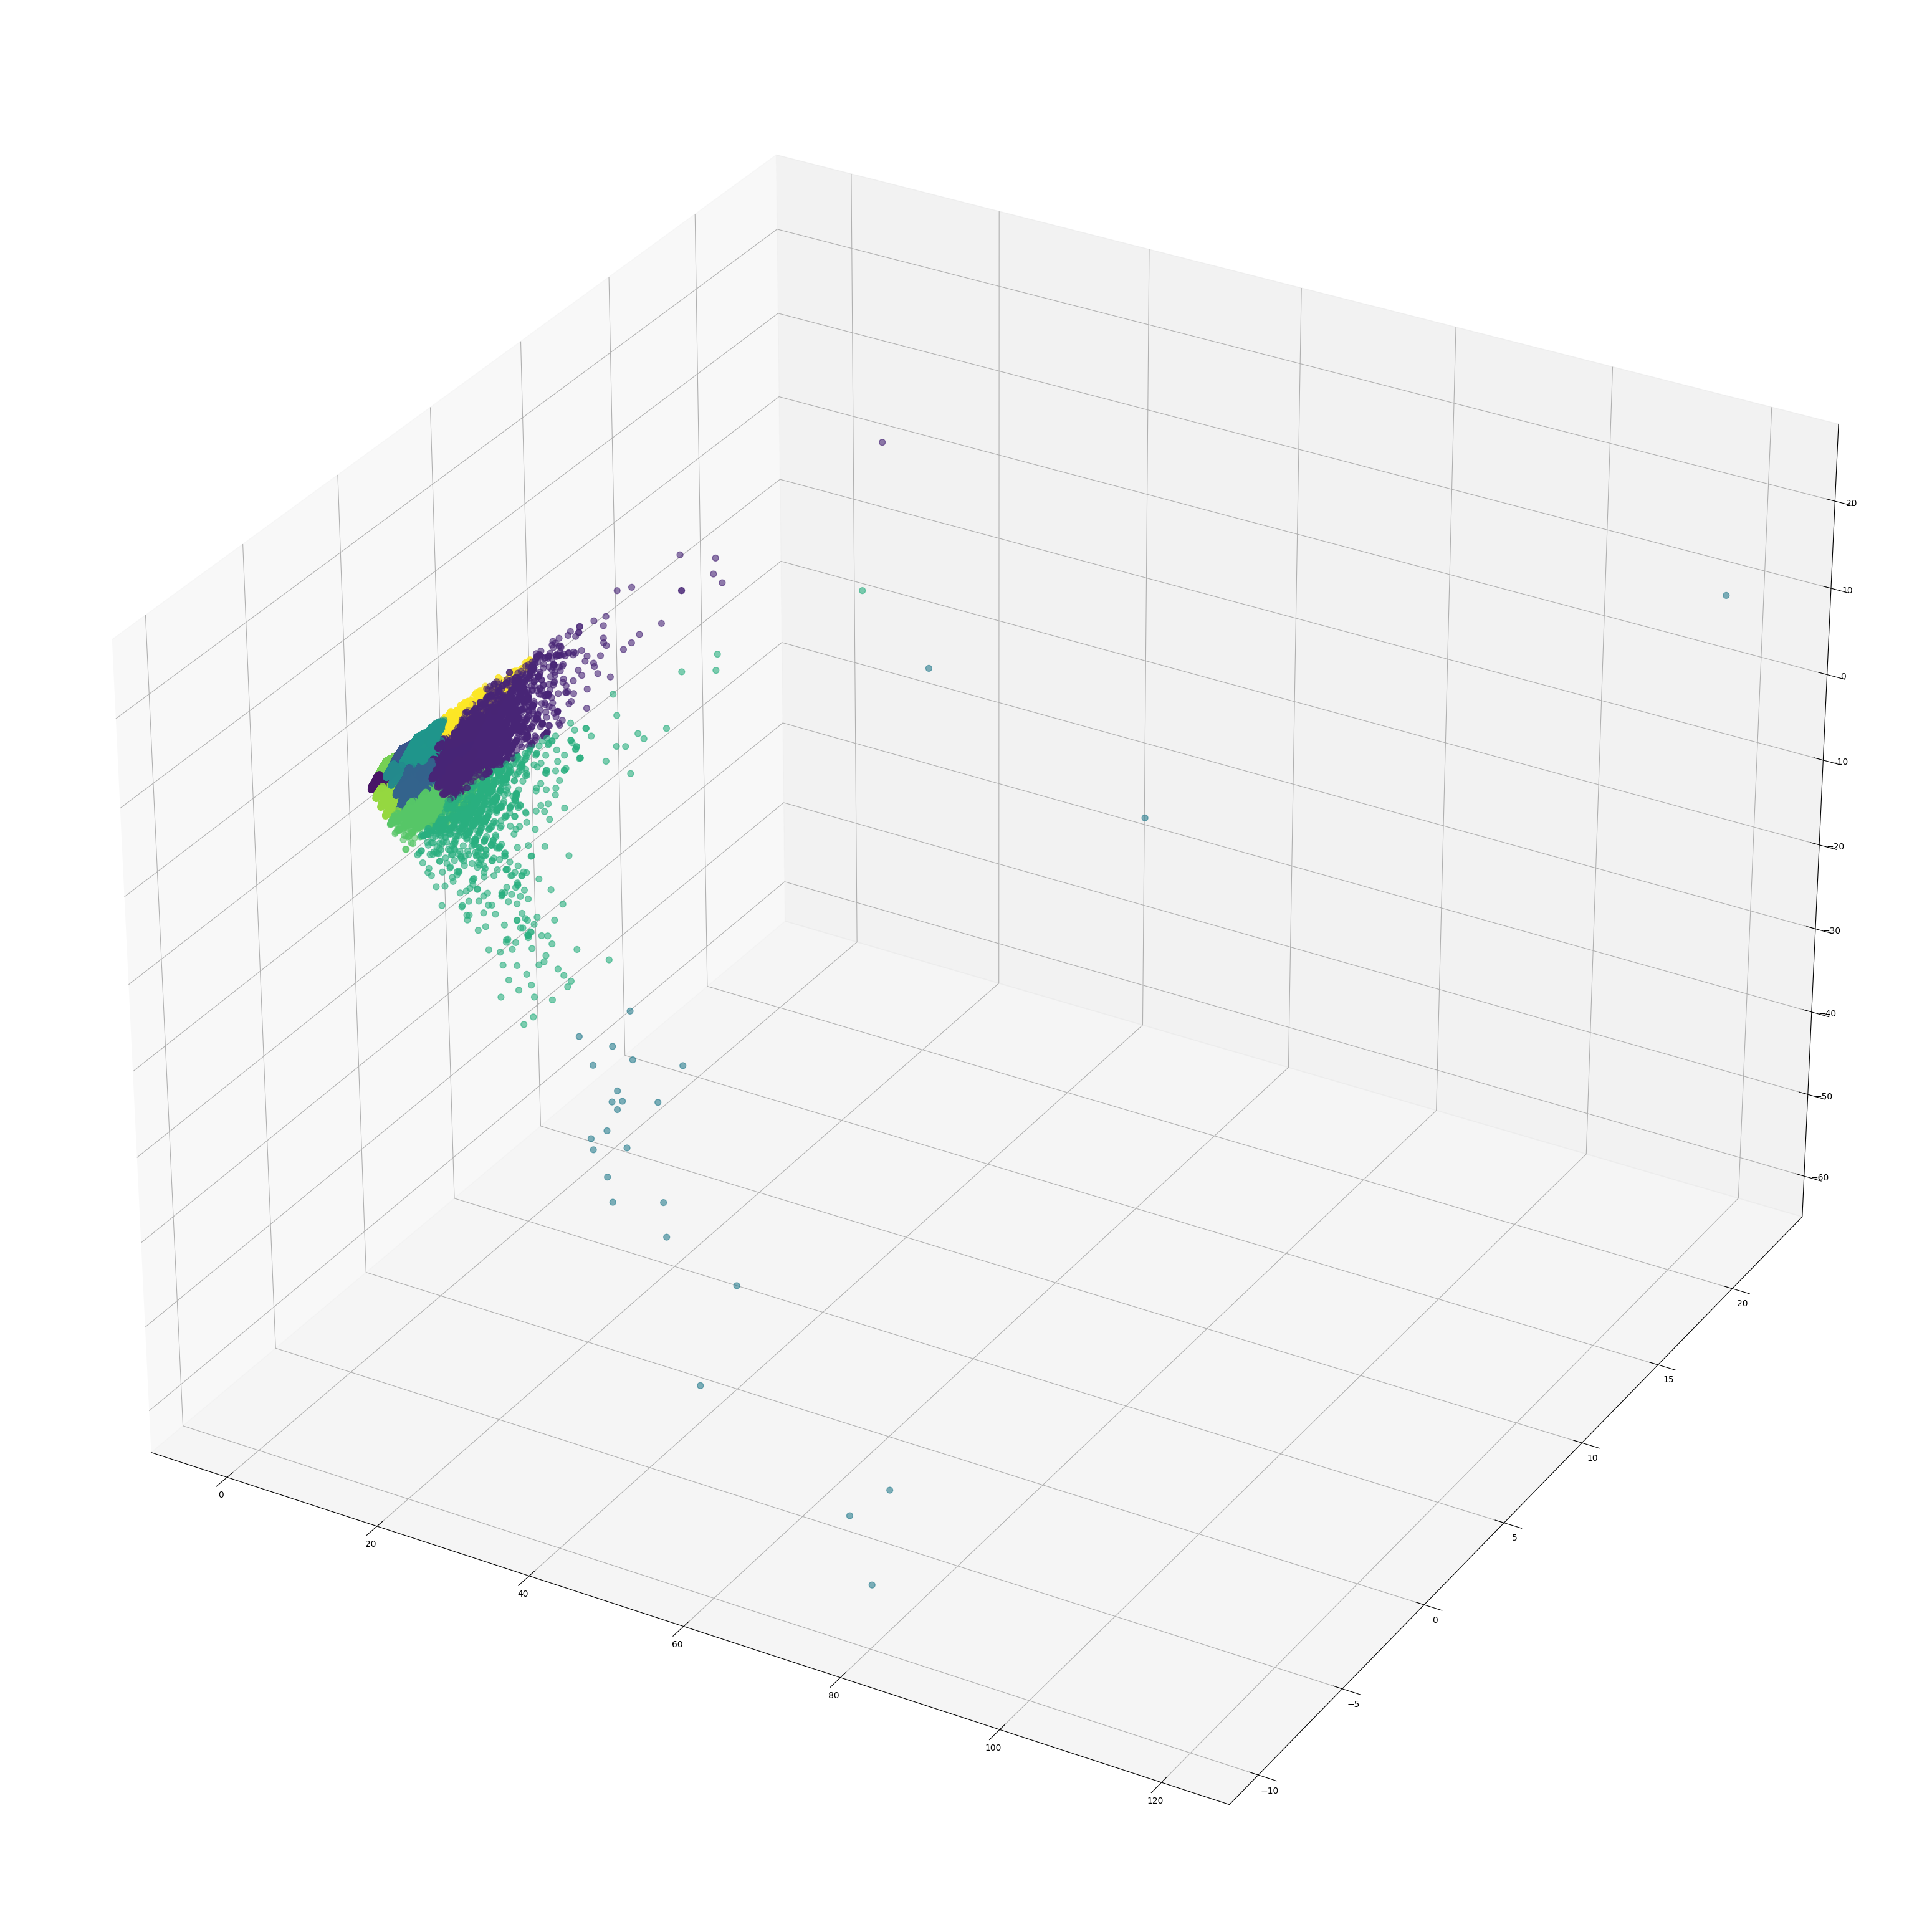

In [21]:
np_pca3 = df_pca3.to_numpy()

fig = plt.figure(figsize=(50, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot data points, colored by cluster
ax.scatter(np_pca3[:, 0], np_pca3[:, 1], np_pca3[:, 2], c=labels3, cmap='viridis', s=50, alpha=0.6)

# Plot centroids
ax.scatter(centroids3[:, 0], centroids3[:, 1], centroids3[:, 2],
           marker='x', s=600, linewidths=3, color='red', label='Centroids')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('K-Means Clustering in 3D')
ax.legend()
plt.show()